# Baseline Models

Baseline models made by using `DummyRegression` and `permutation_test_score`.

In [1]:
#Imports

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.dummy import DummyRegressor

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import permutation_test_score
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
shuffle_split_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

Let's load the data and split into training and test

In [3]:
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=42)

## `LinearRegression` 

In [4]:
lin_reg_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                                ("lin_reg", LinearRegression())])

lin_reg_cv_results = cross_validate(lin_reg_pipeline, train_features,
                                    train_labels, cv=shuffle_split_cv,
                                    scoring="neg_mean_squared_error",
                                    n_jobs=2)

lin_reg_errors = pd.Series(-lin_reg_cv_results["test_score"],
                            name="Linear regression error")

## `DummyRegressor`

In [5]:
def dummy_regressor_baseline(strategy, constant_val=None, quantile_val=None):
    
    baseline_model_median = DummyRegressor(strategy=strategy,
                                            constant=constant_val,
                                            quantile=quantile_val)

    baseline_median_cv_results = cross_validate(baseline_model_median,
                                                train_features, train_labels,
                                                cv=shuffle_split_cv,
                                                scoring="neg_mean_absolute_error",
                                                n_jobs=2)
    
    return pd.Series(-baseline_median_cv_results["test_score"],
                            name="Dummy regressor error")

In [6]:
baseline_median_cv_results_error = dummy_regressor_baseline(strategy = 'median')
baseline_mean_cv_results_error = dummy_regressor_baseline(strategy = 'mean')
baseline_constant_cv_results_error = dummy_regressor_baseline(strategy = 'constant', constant_val=2)
baseline_quantile_cv_results_error = dummy_regressor_baseline(strategy = 'quantile', quantile_val=0.55)

Let's compare the performance of these dummy regressors

In [7]:
dummy_error_df = pd.concat([baseline_median_cv_results_error,
                            baseline_mean_cv_results_error,
                            baseline_constant_cv_results_error,
                            baseline_quantile_cv_results_error],
                            axis=1)
            
dummy_error_df.columns = ['Median cv', 'Mean cv', 'Constant cv', 'Quantile cv']

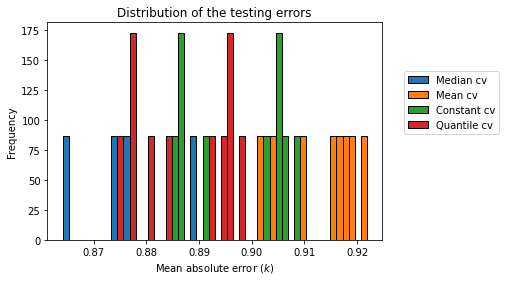

In [8]:
dummy_error_df.plot.hist(bins=50, density=True, edgecolor="black")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.xlabel("Mean absolute error ($k$)")
_ = plt.title("Distribution of the testing errors")

## `permutation_test_score`

It permutes the target to generate randomised data and computes the emperical p-value against the null hypothesis, that the features and targets are independent.

In [9]:
score, permutation_score, pvalue = permutation_test_score(lin_reg_pipeline,
                                                            train_features,
                                                            train_labels,
                                                            cv=shuffle_split_cv,
                                                            scoring="neg_mean_absolute_error",
                                                            n_jobs=2, n_permutations=30)

permutation_errors = pd.Series(-permutation_score, name="Permuted error")

print(permutation_score)

[-0.91446539 -0.91608713 -0.91501122 -0.91112203 -0.91326112 -0.91428719
 -0.91694297 -0.90660687 -0.90873595 -0.91546138 -0.9084695  -0.91174023
 -0.91857102 -0.91467076 -0.90396709 -0.91239289 -0.91095499 -0.91729623
 -0.90529415 -0.91436609 -0.91993036 -0.91661883 -0.91104746 -0.91563156
 -0.91014294 -0.91526135 -0.90680247 -0.90796435 -0.91032999 -0.91545574]


## Model Comparison

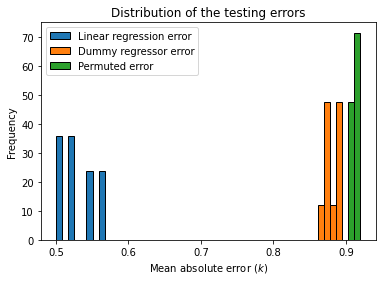

In [10]:
error_df = pd.concat([lin_reg_errors, baseline_median_cv_results_error, permutation_errors],
                        axis = 1)

error_df.plot.hist(bins=50, density=True, edgecolor="black")
plt.legend(loc="best")
plt.xlabel("Mean absolute error ($k$)")
_ = plt.title("Distribution of the testing errors")